<a href="https://colab.research.google.com/github/HWAN722/Deep-learning-models/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

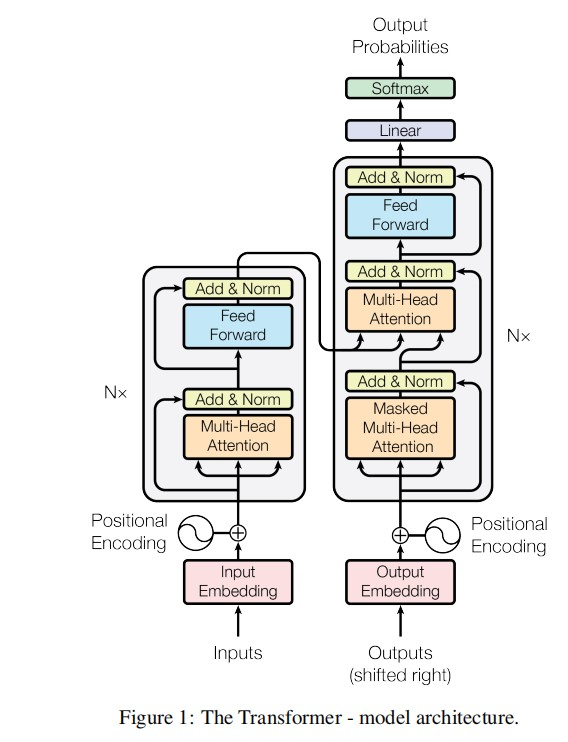

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

def scale_dot_product(q, k, v, mask: Tensor = None):
  d_k = k.size()[-1]
  scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)
  if mask:
    scores = scores.masked_fill(mask == 0, float('-inf'))
  p_attn = F.softmax(scores, dim=-1)
  values = torch.matmul(p_attn, v)
  return values

class AttentionHead(nn.Module):
  def __init__(self, embed_dim, dim_q, dim_k):
    super().__init__()
    self.linear_Q = nn.Linear(embed_dim, dim_q)
    self.linear_K = nn.Linear(embed_dim, dim_k)
    self.linear_V = nn.Linear(embed_dim, dim_k)

  def forward(self, q, k, v, mask):
    return scale_dot_product(self.linear_Q(q), self.linear_K(k), self.linear_V(v), mask)


class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim, num_heads, dim_q, dim_k):
    super().__init__()
    self.heads = nn.ModuleList([AttentionHead(embed_dim, dim_q, dim_k) for _ in range(num_heads)])
    self.linear = nn.Linear(embed_dim, embed_dim)

  def forward(self, q, k, v, mask=None):
    return self.linear(torch.cat([head(q, k, v, mask) for head in self.heads], dim=-1))


def feed_forward(embed_dim, hidden_dim) -> nn.Sequential:
  return nn.Sequential(
      nn.Linear(embed_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, embed_dim)
  )


class Residual(nn.Module):
  def __init__(self, sublayer:nn.Module, dimension, dropout=0.1):
    super().__init__()
    self.sublayer = sublayer
    self.norm = nn.LayerNorm(dimension)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, *args, **kwargs):
    return self.norm(x + self.dropout(self.sublayer(x, *args, **kwargs)))

def positional_encoding(max_len, d_model):
  def get_angle(pos, i, d_model):
    angle_rate = 1 / np.power(10000, 2 * (i // 2) / d_model)
    return pos * angle_rate

  angle_rads = get_angle(np.arange(max_len)[:, np.newaxis],
               np.arange(d_model)[np.newaxis, :],
               d_model)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[np.newaxis, ...]
  return torch.tensor(pos_encoding, dtype=torch.float32)

class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, ffn_dim, dropout=0.1):
    super().__init__()
    query_dim = key_dim = max(embed_dim // num_heads, 1)
    self.multi_head_attention = Residual(
        MultiHeadAttention(embed_dim, num_heads, query_dim, key_dim),
        embed_dim,
        dropout)
    self.feed_forward = Residual(
        feed_forward(embed_dim, ffn_dim),
        embed_dim,
        dropout)

  def forward(self, src, mask):
    return self.feed_forward(self.multi_head_attention(src, src, src, mask))

class TransformerEncoder(nn.Module):
  def __init__(self, num_layers, embed_dim, num_heads, ffn_dim, dropout=0.1):
    super().__init__()
    self.layers = nn.ModuleList([TransformerEncoderLayer(embed_dim, num_heads, ffn_dim, dropout) for _ in range(num_layers)])

  def forward(self, x, mask=None):
    seq_len = x.size(1)
    dimension=x.size(2)
    x = x + positional_encoding(seq_len, dimension)
    for layer in self.layers:
      x = layer(x, mask)
    return x

class TransformerDecoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, ffn_dim, dropout=0.1):
    super().__init__()
    head_dim = embed_dim // num_heads
    self.self_attention = Residual(
        MultiHeadAttention(embed_dim, num_heads, head_dim, head_dim),
        embed_dim,
        dropout)
    self.cross_attention = Residual(
        MultiHeadAttention(embed_dim, num_heads, head_dim, head_dim),
        embed_dim,
        dropout)
    self.feed_forward = Residual(
        feed_forward(embed_dim, ffn_dim),
        embed_dim,
        dropout)

  def forward(self, src, memory):
    target = self.self_attention(src, src, src)
    target = self.cross_attention(target, memory, memory)
    target = self.feed_forward(target)
    return target

class TransformerDecoder(nn.Module):
  def __init__(self, num_layers, embed_dim, num_heads, ffn_dim, dropout=0.1):
    super().__init__()
    self.layers = nn.ModuleList([TransformerDecoderLayer(embed_dim, num_heads, ffn_dim, dropout) for _ in range(num_layers)])
    self.final_layer = nn.Linear(embed_dim, embed_dim)

  def forward(self, x, memory):
    seq_len = x.size(1)
    dimension=x.size(2)
    x = x + positional_encoding(seq_len, dimension)
    for layer in self.layers:
      x = layer(x, memory)
    return torch.softmax(self.final_layer(x), dim=-1)

class Transformer(nn.Module):
  def __init__(self, num_layers, embed_dim, num_heads, ffn_dim, dropout=0.1):
    super().__init__()
    self.encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ffn_dim, dropout)
    self.decoder = TransformerDecoder(num_layers, embed_dim, num_heads, ffn_dim, dropout)

  def forward(self, src, target):
    return self.decoder(target, self.encoder(src))

batch_size=2
seq_len=4
embd_dim=8

src = torch.rand(batch_size, seq_len, embd_dim)
tgt = torch.rand(batch_size, seq_len, embd_dim)

transformer = Transformer(2, embd_dim, 4, 512)
out = transformer(src, tgt)

print(out)

tensor([[[0.1168, 0.2803, 0.1683, 0.0902, 0.1422, 0.0383, 0.0710, 0.0928],
         [0.1823, 0.2655, 0.2118, 0.0644, 0.0878, 0.0349, 0.0721, 0.0811],
         [0.0733, 0.2106, 0.2163, 0.1644, 0.1097, 0.0377, 0.1273, 0.0607],
         [0.1081, 0.2020, 0.2399, 0.1393, 0.1315, 0.0533, 0.0804, 0.0455]],

        [[0.0863, 0.2675, 0.1442, 0.0961, 0.2130, 0.0613, 0.0719, 0.0597],
         [0.0707, 0.3198, 0.1672, 0.1015, 0.1490, 0.0355, 0.1050, 0.0512],
         [0.1055, 0.3089, 0.1976, 0.0831, 0.0708, 0.0422, 0.1305, 0.0613],
         [0.1517, 0.1746, 0.2054, 0.1335, 0.1468, 0.0736, 0.0582, 0.0562]]],
       grad_fn=<SoftmaxBackward0>)
